In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [4]:
def prepare_dataset(input_ds):
    ds = input_ds.map(lambda img, label: img)

    # cast datatype to float
    ds = ds.map(lambda img: tf.cast(img, tf.float32))

    # normalize values
    ds = ds.map(lambda img: img/128. - 1.)

    # create pair of images
    ds = ds.map(lambda img: (img, img))

    # add noise
    ds = ds.map(lambda img1, img2: (tf.clip_by_value(img1 + tf.random.normal(img1.shape, mean=0, stddev=0.5), clip_value_min=-1, clip_value_max=1), img2))

    ds = ds.shuffle(1000) 
    ds = ds.batch(32)
    ds = ds.prefetch(tf.data.AUTOTUNE)

    return ds

In [5]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, optimizer):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=2, padding="same", activation="relu", input_shape=(28,28,1))
        self.norm1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding="same", activation="relu", input_shape=(14,14,1))
        self.norm2 = tf.keras.layers.BatchNormalization()
        self.flatten = tf.keras.layers.Flatten()
        self.out = tf.keras.layers.Dense(32, activation="relu")

    @tf.function
    def call(self, x, training=False):
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.flatten(x)
        return self.out(x)

In [6]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, optimizer):
        super().__init__()
        self.dense1 = tf.keras.layers.Dense(7 * 7, activation="relu")
        self.reshape = tf.keras.layers.Reshape((7, 7, 1))
        self.convt1 = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding="same", activation="relu")
        self.norm1 = tf.keras.layers.BatchNormalization()
        self.convt2 = tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding="same", activation="relu")
        self.norm2 = tf.keras.layers.BatchNormalization()
        self.out = tf.keras.layers.Conv2D(filters=1, kernel_size=3, padding="same", activation="sigmoid")

    @tf.function
    def call(self, x, training=False):
        x = self.dense1(x)
        x = self.reshape(x)
        x = self.convt1(x)
        x = self.norm1(x)
        x = self.convt2(x)
        x = self.norm2(x)
        return self.out(x)

In [7]:
class Autoencoder(tf.keras.Model):
    def __init__(self, optimizer):
        super().__init__()
        self.encoder = Encoder(optimizer)
        self.decoder = Decoder(optimizer)
    
    @tf.function
    def call(self, x, training=False):
        x = self.encoder(x)
        return self.decoder(x)

In [8]:
(train_dataset, test_dataset), ds_info = tfds.load(
    "mnist", split=["train", "test"], as_supervised=True, with_info=True
)
train_ds = prepare_dataset(train_dataset)
test_ds = prepare_dataset(test_dataset)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [9]:
autoencoder = Autoencoder(tf.keras.optimizers.Adam())

In [10]:
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(), loss="mean_squared_error")
autoencoder.fit(train_ds, validation_data=test_ds, batch_size=32, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 27s 9ms/step - loss: 0.9294 - val_loss: 0.8927
Epoch 2/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.8919 - val_loss: 0.8886
Epoch 3/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.8898 - val_loss: 0.8871
Epoch 4/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.8885 - val_loss: 0.8862
Epoch 5/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.8878 - val_loss: 0.8856
Epoch 6/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.8870 - val_loss: 0.8852
Epoch 7/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.8865 - val_loss: 0.8841
Epoch 8/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.8860 - val_loss: 0.8839
Epoch 9/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.8855 - val_loss: 0.8845
Epoch 10/10
1875/1875 [==============================] - 16s 8ms/step - l

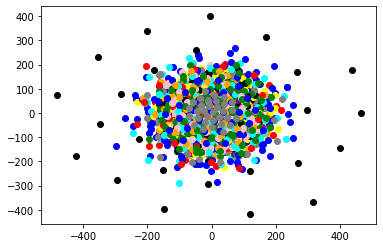

In [23]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

colors = {0: "red",
              1: "cyan",
              2: "yellow",
              3: "purple",
              4: "pink",
              5: "orange",
              6: "grey",
              7: "blue",
              8: "black",
              9: "green",
              }

def prepare_img(img):
    img = tf.cast(img, tf.float32)
    img = img/128. - 1.
    img = tf.expand_dims(img, axis=0)
    return img

for img, label in test_dataset.take(100):
    img = prepare_img(img)

    output = autoencoder.encoder(img).reshape(-1, 1)

    output_embedded = TSNE(n_components=2).fit_transform(output)

    x1 = output_embedded[:, 0]
    x2 = output_embedded[:, 1]

    plt.plot(x1, x2, 'o', color=colors[label.numpy()])

There does not really seem to be a pattern. This might very well be due to an error in our code, as we expected the different classes to occupy different regions.